<a href="https://colab.research.google.com/github/SaiRajesh228/DeepLearningAssignment1/blob/main/q11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

import wandb
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Cost after iteration 0: 2.4082821845499467
Cost after iteration 100: 1.1828420833931232
Cost after iteration 200: 0.9087517175558829
Cost after iteration 300: 0.7972991291844501
Cost after iteration 400: 0.732279601679482
Cost after iteration 500: 0.6875174991547955
Cost after iteration 600: 0.653676215532101
Cost after iteration 700: 0.6266989794939206
Cost after iteration 800: 0.6047104801620315
Cost after iteration 900: 0.5864510112561303
Training Accuracy: 80.70%
Test Accuracy: 79.61%


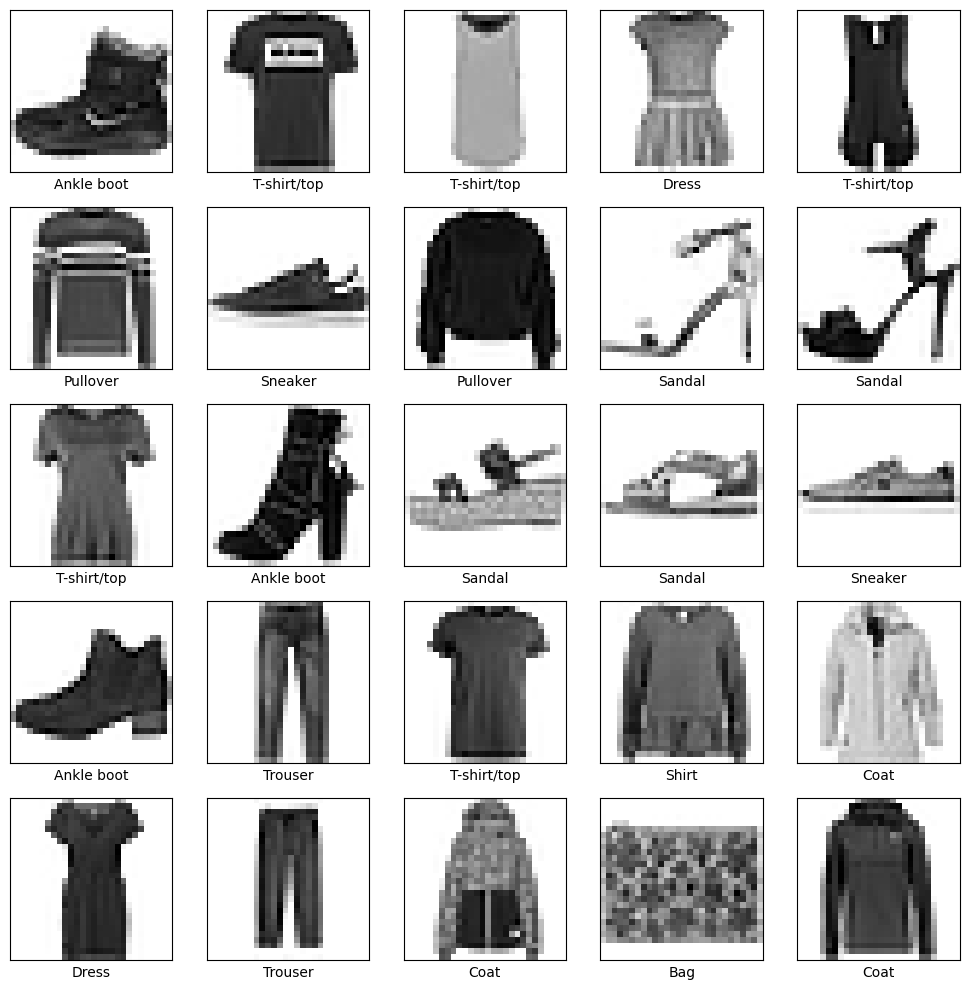

In [5]:
import pandas as pd
import numpy as np
import wandb
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import os

# 🚀 Configure WandB with increased timeout and offline mode
wandb_settings = wandb.Settings(init_timeout=300)
os.environ["WANDB_API_KEY"] = "your-api-key"

# 📌 Initialize WandB project in offline mode
run = wandb.init(project="DLAssignment1", settings=wandb_settings, mode="offline")

# 📌 Question 1: Load and visualize Fashion MNIST
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.tight_layout()
wandb.log({"Sample Images": plt})

# 📌 Question 2: Data preprocessing
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels].T

X_train = train_images.reshape(-1, 784).T / 255.0
Y_train = one_hot_encode(train_labels)

X_test = test_images.reshape(-1, 784).T / 255.0
Y_test = one_hot_encode(test_labels)

# 📌 Question 3: Parameter initialization
def initialize_parameters(layer_dims, initialization='he'):
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        if initialization == 'he':
            parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2./layer_dims[l-1])
        elif initialization == 'xavier':
            parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(1./layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

# 📌 Question 4: Activation functions
def relu(Z):
    return np.maximum(0, Z)

def softmax(Z):
    exps = np.exp(Z - np.max(Z))
    return exps / np.sum(exps, axis=0, keepdims=True)

# 📌 Question 5: Forward propagation
def forward_propagation(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        Z = np.dot(W, A_prev) + b
        A = relu(Z)
        caches.append((Z, A_prev, W))

    W = parameters['W' + str(L)]
    b = parameters['b' + str(L)]
    Z = np.dot(W, A) + b
    AL = softmax(Z)
    caches.append((Z, A, W))

    return AL, caches

# 📌 Question 6: Compute cost
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -1/m * np.sum(Y * np.log(AL + 1e-8))
    return cost

# 📌 Question 7: Backward propagation
def backward_propagation(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]

    dZ = AL - Y
    grads['dW' + str(L)] = 1/m * np.dot(dZ, caches[L-1][1].T)
    grads['db' + str(L)] = 1/m * np.sum(dZ, axis=1, keepdims=True)

    for l in reversed(range(L-1)):
        dA = np.dot(caches[l+1][2].T, dZ)
        dZ = dA * (caches[l][0] > 0)
        grads['dW' + str(l+1)] = 1/m * np.dot(dZ, caches[l][1].T)
        grads['db' + str(l+1)] = 1/m * np.sum(dZ, axis=1, keepdims=True)

    return grads

# 📌 Question 8: Update parameters
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2

    for l in range(1, L+1):
        parameters['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] -= learning_rate * grads['db' + str(l)]

    return parameters

# 📌 Main training loop
def model(X, Y, layers_dims, learning_rate=0.01, num_iterations=1000):
    parameters = initialize_parameters(layers_dims, 'he')
    costs = []

    for i in range(num_iterations):
        AL, caches = forward_propagation(X, parameters)
        cost = compute_cost(AL, Y)
        grads = backward_propagation(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if i % 100 == 0:
            print(f"Cost after iteration {i}: {cost}")
            wandb.log({"Training Loss": cost})
            costs.append(cost)

    return parameters, costs

# 📌 Prediction function
def predict(X, parameters):
    AL, _ = forward_propagation(X, parameters)
    predictions = np.argmax(AL, axis=0)
    return predictions

# 📌 Accuracy computation
def compute_accuracy(predictions, labels):
    accuracy = np.mean(predictions == labels) * 100
    return accuracy

# 🚀 Configure network architecture
layers_dims = [784, 128, 64, 10]
wandb.config.update({
    "learning_rate": 0.01,
    "epochs": 1000,
    "batch_size": "full",
    "layer_dims": layers_dims,
    "activation": "relu",
    "output_activation": "softmax"
})

# 🚀 Train the model
parameters, costs = model(X_train, Y_train, layers_dims)

# 🚀 Evaluate the model
train_preds = predict(X_train, parameters)
test_preds = predict(X_test, parameters)

train_accuracy = compute_accuracy(train_preds, train_labels)
test_accuracy = compute_accuracy(test_preds, test_labels)

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

wandb.log({"Training Accuracy": train_accuracy, "Test Accuracy": test_accuracy})

# 🚀 Save and finish
wandb.finish()